<a href="https://colab.research.google.com/github/Femonello/bootcamp-data-analytics/blob/main/Desafio_4_Squad_Fernanda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Desafi o 3: Suplementos Alimentares**

Imagine que você trabalha em uma empresa que fabrica suplementos alimentares. O time de produtos quer entender qual das três novas fórmulas de proteína em pó proporciona maior ganho de massa muscular em atletas.

Foi realizada uma pesquisa com vários atletas e coletados os seguintes dados no arquivo desafi o_03_suplementos.csv

In [25]:
# Importando bibliotecas

#Dados
import pandas as pd
import numpy as np

#Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

#Estatística
from scipy import stats

import warnings
warnings.filterwarnings("ignore")



### **ETL**

1. Extração

In [26]:
#configurando URL a partir do id do arquivo compartilhado

id_do_arquivo = "1Fhv43MTX13YkyMxDUBNzdmZmzpZbgH1b"
url = f'https://drive.google.com/uc?id={id_do_arquivo}&export=download'


In [27]:
df = pd.read_csv(url)
df.head()

,id_produto,id_atleta,ganho_massa,idade,frequencia_treino
0,Fórmula 3,1,2.24,27,5
1,Fórmula 1,2,4.97,35,4
2,Fórmula 3,3,0.88,30,6
3,Fórmula 3,4,0.09,22,6
4,Fórmula 1,5,2.47,18,6


In [28]:
# analisando o tamanho do dataset e os tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_produto         300 non-null    object 
 1   id_atleta          300 non-null    int64  
 2   ganho_massa        300 non-null    float64
 3   idade              300 non-null    int64  
 4   frequencia_treino  300 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 11.8+ KB


In [29]:
# convertendo id_atleta para string
df['id_atleta'] = df['id_atleta'].astype(str)


In [30]:
#Verificando características dos dados
df.describe()

,ganho_massa,idade,frequencia_treino
count,300.000000,300.000000,300.000000
mean,2.466733,28.123333,3.993333
std,1.436384,6.493742,1.430657
min,0.030000,18.000000,2.000000
25%,1.267500,22.000000,3.000000
50%,2.400000,28.000000,4.000000
75%,3.612500,34.000000,5.000000
max,4.980000,39.000000,6.000000


▶ Ganho de massa: não apresenta valores negativos, o que indica coerencia nos registros

▶ Frequencia de treino na semana também apresenta valores coerentes, sendo o máximo 6 vezes.

In [31]:
# Verificando escrita das do id produto para evitar contabilização incorreta
df['id_produto'].unique()

array(['Fórmula 3', 'Fórmula 1', 'Fórmula 2'], dtype=object)

### **Análise exploratória dos dados**

⏩ **Qual é a média e a mediana do ganho de massa para cada suplemento?**

In [32]:
#média e mediana por id_produto através da função agg para apresentação dos resultados em uma tabela

df_estatisticas = df.groupby('id_produto').agg({'ganho_massa': ['mean', 'median']})
df_estatisticas.columns = ['Média', 'Mediana']

display(df_estatisticas.style.set_caption("Média e Mediana de Ganho de Massa por Suplemento")
      .format({"Média de Ganho (kg)": "{:.2f}", "Mediana de Ganho (kg)": "{:.2f}"}))


,Média,Mediana
id_produto,,
Fórmula 1,2.656566,2.670000
Fórmula 2,2.350106,2.150000
Fórmula 3,2.393551,2.350000


⏩ **Como os dados estão distribuídos? Utilize histogramas e boxplots para visualizar as diferenças entre as fórmulas.**

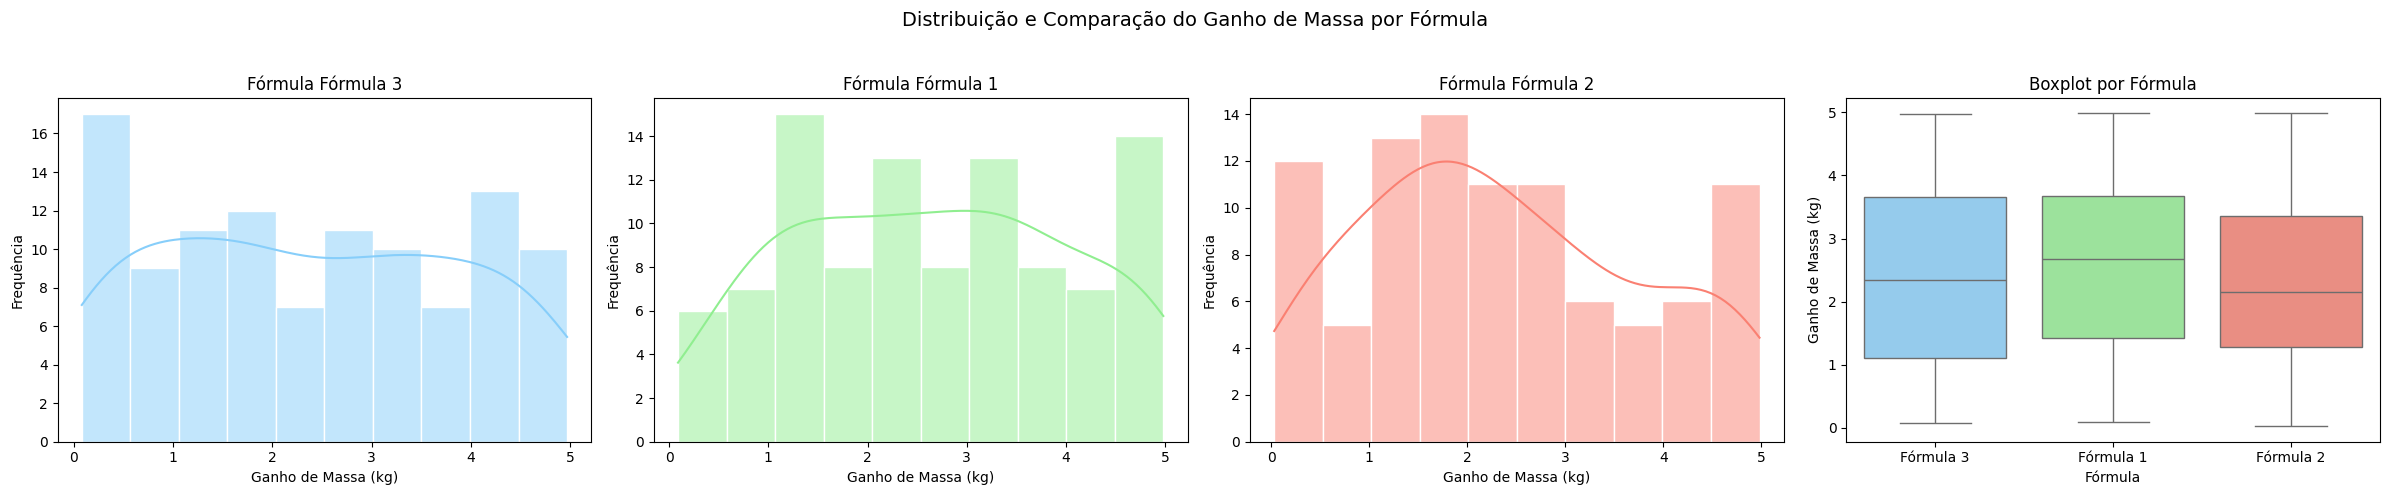

In [33]:

# Paleta personalizada
custom_palette = ['lightskyblue', 'lightgreen', 'salmon']

# Fórmulas disponíveis
formulas = df['id_produto'].unique()

# Criação da figura com 1 linha e 4 colunas (3 histogramas + 1 boxplot)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 5), sharey=False)

# Histogramas separados por fórmula (colunas 0 a 2)
for i, formula in enumerate(formulas):
    subset = df[df['id_produto'] == formula]
    sns.histplot(subset['ganho_massa'], kde=True, bins=10,
                 color=custom_palette[i], edgecolor='white', ax=axes[i])
    axes[i].set_title(f'Fórmula {formula}')
    axes[i].set_xlabel('Ganho de Massa (kg)')
    axes[i].set_ylabel('Frequência')

# Boxplot comparativo na última coluna (coluna 3)
sns.boxplot(x='id_produto', y='ganho_massa', data=df, palette=custom_palette, ax=axes[3])
axes[3].set_title('Boxplot por Fórmula')
axes[3].set_xlabel('Fórmula')
axes[3].set_ylabel('Ganho de Massa (kg)')

plt.suptitle('Distribuição e Comparação do Ganho de Massa por Fórmula', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


* Verificamos nos histogramas, ma distribuição semelhante entre as três diferentes formulas. As formulas 1 e 2 apresentam uma frequência mais nitidamente concentrada nos ganhos de massa entre 1 e 3 kg, enquanto a formula 3 tem uma distribuição com características mais continua.

* No boxsplot, verificamos que não há presença relevante de outliers nos dados, bem como há um comportamento muito semelhante na distribuição dos percentis, sendo a formula 2, representada com maior concentração de dados em relação à média e mediana.

⏩ **Há diferença estatisticamente significativa no ganho de massa muscular entre as três fórmulas?**




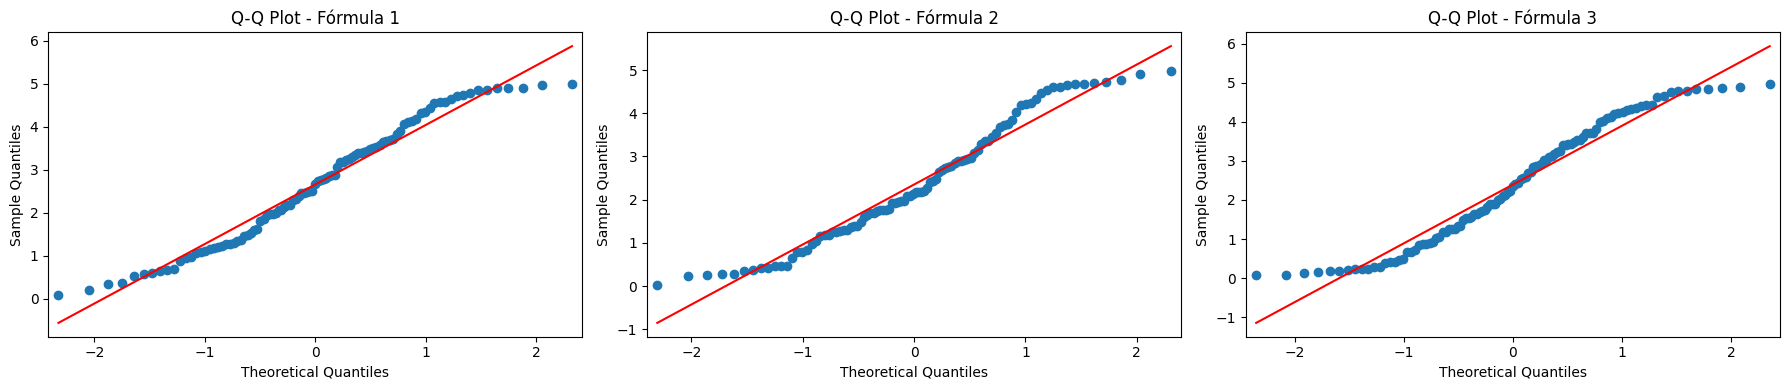

In [34]:
# Teste de Hipótese (H0 - não há diferenças // H1 - há diferenças)

#Passo 1 - analisando a normalidade

import statsmodels.api as sm
import matplotlib.pyplot as plt

# Lista de fórmulas
formulas = ['Fórmula 1', 'Fórmula 2', 'Fórmula 3']

# Cores personalizadas
custom_palette = ['lightskyblue', 'lightgreen', 'salmon']

# Criar subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Gerar Q-Q plot para cada fórmula
for i, formula in enumerate(formulas):
    grupo = df[df['id_produto'] == formula]['ganho_massa']
    sm.qqplot(grupo, line='s', ax=axes[i], color=custom_palette[i])
    axes[i].set_title(f'Q-Q Plot - {formula}', fontsize=12)

plt.tight_layout()
plt.show()


* A análise gráfica mostra uma variação dos dads em relação à linha central. Para confirmação, faremos a análise através do teste Teste de Shapiro-Wilk

In [35]:
from scipy.stats import shapiro

# Lista de fórmulas
formulas = ['Fórmula 1', 'Fórmula 2', 'Fórmula 3']

# Teste de Shapiro para cada grupo
for formula in formulas:
    grupo = df[df['id_produto'] == formula]['ganho_massa']
    stat, p = shapiro(grupo)
    print(f'{formula} - Estatística={stat:.4f}, p-valor={p:.4f}')
    if p <0.05:
      print(f'Os dados não seguem uma distribuição normal\n')
    else:
      print(f'Dados seguem uma distribuição normal\n')



Fórmula 1 - Estatística=0.9590, p-valor=0.0036
Os dados não seguem uma distribuição normal

Fórmula 2 - Estatística=0.9524, p-valor=0.0018
Os dados não seguem uma distribuição normal

Fórmula 3 - Estatística=0.9424, p-valor=0.0002
Os dados não seguem uma distribuição normal



* Com a rejeição da H0 do teste de normalidade (distribuição não normal), faremos o uso do teste não parametrico Kruskal-Wallis com alternativa ao ANOVA, para verificação se há uma diferença estatisticamente significativa nas medianas de três ou mais grupos independentes.

In [36]:
#Teste  Kruskal-Wallis (H0 - não há diferenças // H1 - há diferenças)

from scipy.stats import kruskal

# Separa os dados por fórmula
grupo1 = df[df['id_produto'] == 'Fórmula 1']['ganho_massa']
grupo2 = df[df['id_produto'] == 'Fórmula 2']['ganho_massa']
grupo3 = df[df['id_produto'] == 'Fórmula 3']['ganho_massa']

# Teste de Kruskal-Wallis
stat, p = kruskal(grupo1, grupo2, grupo3)

print(f'Estatística={stat:.4f}, p-valor={p:.4f}')
if p < 0.05 :
    print('Rejeita-se H0 - Há diferenças estatisticamente significativas nas medianas dos grupos.')
else:
    print('Não se rejeita H0 - Não há diferenças estatisticamente significativas nas medianas dos grupos.')


Estatística=2.6473, p-valor=0.2662
Não se rejeita H0 - Não há diferenças estatisticamente significativas nas medianas dos grupos.


⏩ **Existe correlação entre idade e ganho de massa muscular? Atletas mais jovens ou mais velhos têm resultados diferentes?**

In [37]:
# Correlação de Pearson entre idade e ganho de massa muscular
correlacao = df['idade'].corr(df['ganho_massa'])
print(f'A correlação entre idade e ganho de massa muscular é: {correlacao:.4f}')


A correlação entre idade e ganho de massa muscular é: -0.0733


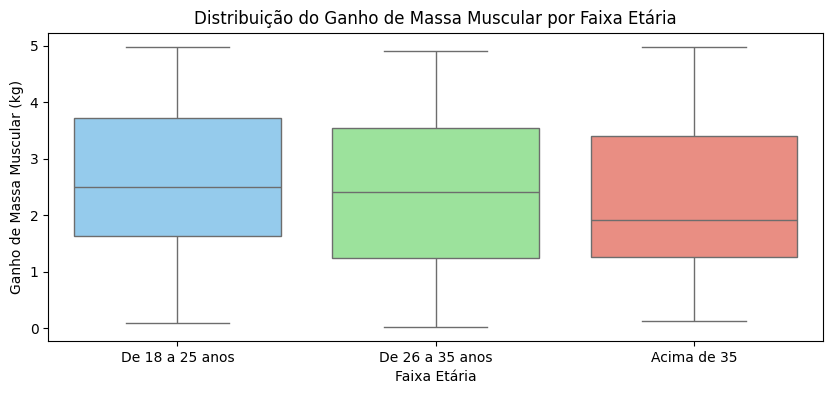

In [42]:
# Paleta personalizada
custom_palette = ['lightskyblue', 'lightgreen', 'salmon']

plt.figure(figsize=(10, 4))

# Dividir em faixas etárias
faixas_etarias = ['De 18 a 25 anos', 'De 26 a 35 anos', 'Acima de 35']
df['faixa_etaria'] = pd.cut(df['idade'], bins=[18, 25, 35, float('inf')],
                                        labels=faixas_etarias, include_lowest=True, right=False)

# Comparar o ganho de massa muscular entre as faixas etárias
sns.boxplot(x='faixa_etaria', y='ganho_massa', data=df, palette=custom_palette)
plt.title('Distribuição do Ganho de Massa Muscular por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Ganho de Massa Muscular (kg)')
plt.show()


* Através do resultado da correlação de Pearson nota-se que o resultado está muito próximo à zero, indicando que não há correlação entre idade e ganho de massa nesse conjunto de dados.

* É possível observar no boxplot que a divisão dos percentis dos dados também estão muito próximas, com um pequeno achatamento para o grupo acima de 35 anos, não indicando uma grande correlação nesse caso quando comparado o resultado geral

Vamos analisar os dados por cada uma das formulas separadamente

In [39]:
# Analisando cada fórmula separadamente
for produto in df['id_produto'].unique():
    # Filtrando dados por fórmula
    df_produto = df[df['id_produto'] == produto]

    # Correlação de Pearson entre idade e ganho de massa muscular
    correlacao = df_produto['idade'].corr(df_produto['ganho_massa'])

    # Exibindo os resultados
    print(f'Correlação de Pearson para a Fórmula {produto}: {correlacao:.4f}')


Correlação de Pearson para a Fórmula Fórmula 3: -0.0404
Correlação de Pearson para a Fórmula Fórmula 1: 0.0397
Correlação de Pearson para a Fórmula Fórmula 2: -0.2469


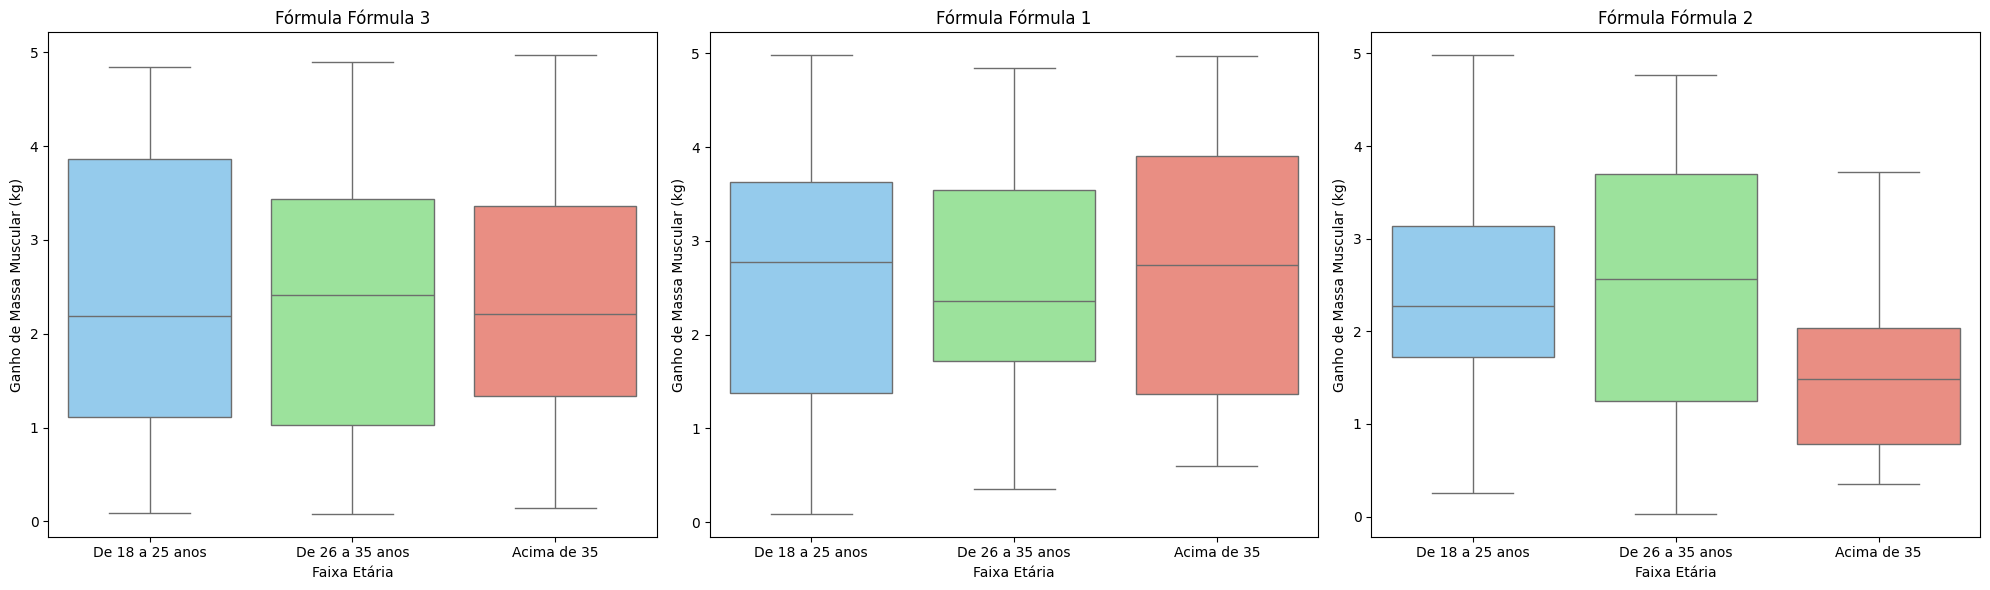

In [43]:
# Paleta de cores
#custom_palette = sns.color_palette('Set2')

# Analisando Boxplot para cada fórmula e faixa etária
fig, axes = plt.subplots(nrows=1, ncols=len(df['id_produto'].unique()), figsize=(20, 6))

# Caso haja apenas uma fórmula, o axes será um único objeto e não uma lista
if len(df['id_produto'].unique()) == 1:
    axes = [axes]

# Gerar os boxplots
for i, produto in enumerate(df['id_produto'].unique()):
    # Filtrando dados por fórmula
    df_produto = df[df['id_produto'] == produto].copy()

    # Criar uma nova coluna para a faixa etária
    #faixas_etarias = ['De 18 a 25 anos', 'De 26 a 35 anos', 'Acima de 36']
    #df_produto['faixa_etaria'] = pd.cut(df_produto['idade'], bins=[18, 25, 35], labels=faixas_etarias)

    # Criar uma nova coluna para a faixa etária
    faixas_etarias = ['De 18 a 25 anos', 'De 26 a 35 anos', 'Acima de 35']
    df_produto['faixa_etaria'] = pd.cut(df_produto['idade'], bins=[18, 25, 35, float('inf')],
                                        labels=faixas_etarias, include_lowest=True, right=False) # Adjust bins and include_lowest

    # Gerar o boxplot para cada fórmula
    sns.boxplot(x='faixa_etaria', y='ganho_massa', data=df_produto, hue='faixa_etaria',
            palette=custom_palette, ax=axes[i], legend=False)
    axes[i].set_title(f'Fórmula {produto}')
    axes[i].set_xlabel('Faixa Etária')
    axes[i].set_ylabel('Ganho de Massa Muscular (kg)')

# Ajustar o layout para que os gráficos não se sobreponham
plt.tight_layout()
plt.show()


* Aqui é possível notar que na fórmula 2 há uma uma redução no ganho de massa para idade da faixa etaria acima de 35 anos no entanto, ainda próximo a zero, o que indica que não há uma correlação forte entre as variáveis.

⏩ **Atletas que treinam mais frequentemente ganham mais massa muscular independentemente do suplemento?**

In [44]:
# Teste de hipotese 2 (H0 -  frequência de treino não influencia o ganho de massa muscular, H1 - A frequência de treino influencia o ganho de massa muscular)


# Correlação de Pearson entre idade e ganho de massa muscular
correlacao = df['frequencia_treino'].corr(df['ganho_massa'])
print(f'A correlação entre frequência de treino e ganho de massa muscular é: {correlacao:.4f}')



A correlação entre frequência de treino e ganho de massa muscular é: 0.0787


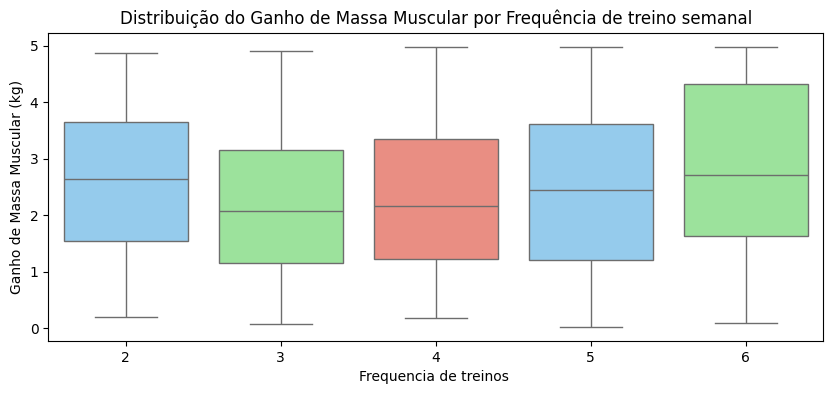

In [52]:
plt.figure(figsize=(10, 4))

# Dividir em faixas de frequência de treinamento
#faixas_feq_treinamento = ['2-3 vezes por semana', '3-4 vezes por semana', '4-5 vezes por semana', '5+ vezes por semana']

#df['frequencia_treino_cat'] = pd.cut(df['frequencia_treino'], bins=[2, 3, 4, 5, float('inf')],
#                                        labels=faixas_feq_treinamento, include_lowest=True, right=False,duplicates='drop')

# Comparar o ganho de massa muscular entre as frequências de treinamento
sns.boxplot(x='frequencia_treino', y='ganho_massa', data=df, palette=custom_palette)
plt.title('Distribuição do Ganho de Massa Muscular por Frequência de treino semanal')
plt.xlabel('Frequencia de treinos ')
plt.ylabel('Ganho de Massa Muscular (kg)')
plt.show()

* Nota-se que o grupo com uma frequência de treinamento de 6 vezes por semana apresenta uma maior variação dos dados de ganho de massa, com uma dispersão e amplitude maior. No entando, a mediana dos dados mantem-se muito próxima das demais categorias. Além disso, o teste de correção com resultado muito próximo a zero, indica que não há uma relação linear clara entre a frequencia de treinamento e o ganho de massa.



In [58]:
# Teste de hipótese 2 para cada fórmula
# H0: frequência de treino não influencia o ganho de massa muscular
# H1: frequência de treino influencia o ganho de massa muscular

for produto in df['id_produto'].unique():
    df_produto = df[df['id_produto'] == produto]

    correlacao = df_produto['frequencia_treino'].corr(df_produto['ganho_massa'])

    print(f'Fórmula {produto}: correlação entre frequência de treino e ganho de massa muscular = {correlacao:.4f}')


Fórmula Fórmula 3: correlação entre frequência de treino e ganho de massa muscular = 0.1500
Fórmula Fórmula 1: correlação entre frequência de treino e ganho de massa muscular = 0.0461
Fórmula Fórmula 2: correlação entre frequência de treino e ganho de massa muscular = 0.0200


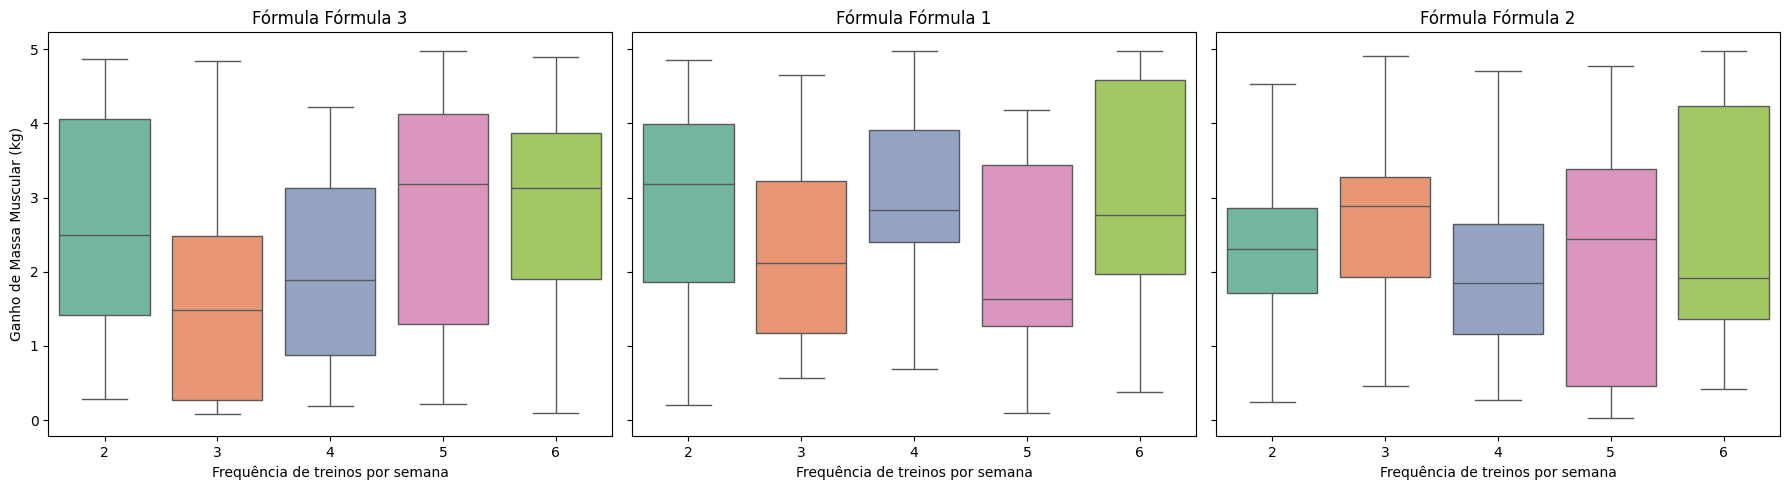

In [60]:


# Obter os produtos únicos
produtos = df['id_produto'].unique()

# Criar uma figura com subplots (um para cada fórmula)
fig, axes = plt.subplots(1, len(produtos), figsize=(6 * len(produtos), 5), sharey=True)

# Garantir que axes seja uma lista mesmo com um único subplot
if len(produtos) == 1:
    axes = [axes]

# Loop por fórmula
for i, produto in enumerate(produtos):
    df_produto = df[df['id_produto'] == produto]

    sns.boxplot(
        x='frequencia_treino',
        y='ganho_massa',
        data=df_produto,
        palette=custom_palette,
        ax=axes[i]
    )

    axes[i].set_title(f'Fórmula {produto}')
    axes[i].set_xlabel('Frequência de treinos por semana')
    axes[i].set_ylabel('Ganho de Massa Muscular (kg)')

plt.tight_layout()
plt.show()


⏩ **Existe alguma correlação entre idade, frequência de treino e a eficácia do suplemento?**

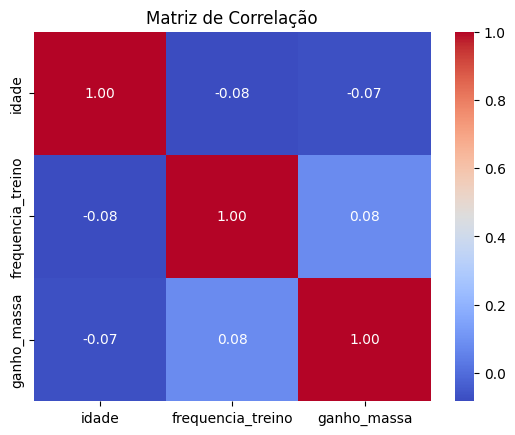

In [55]:
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

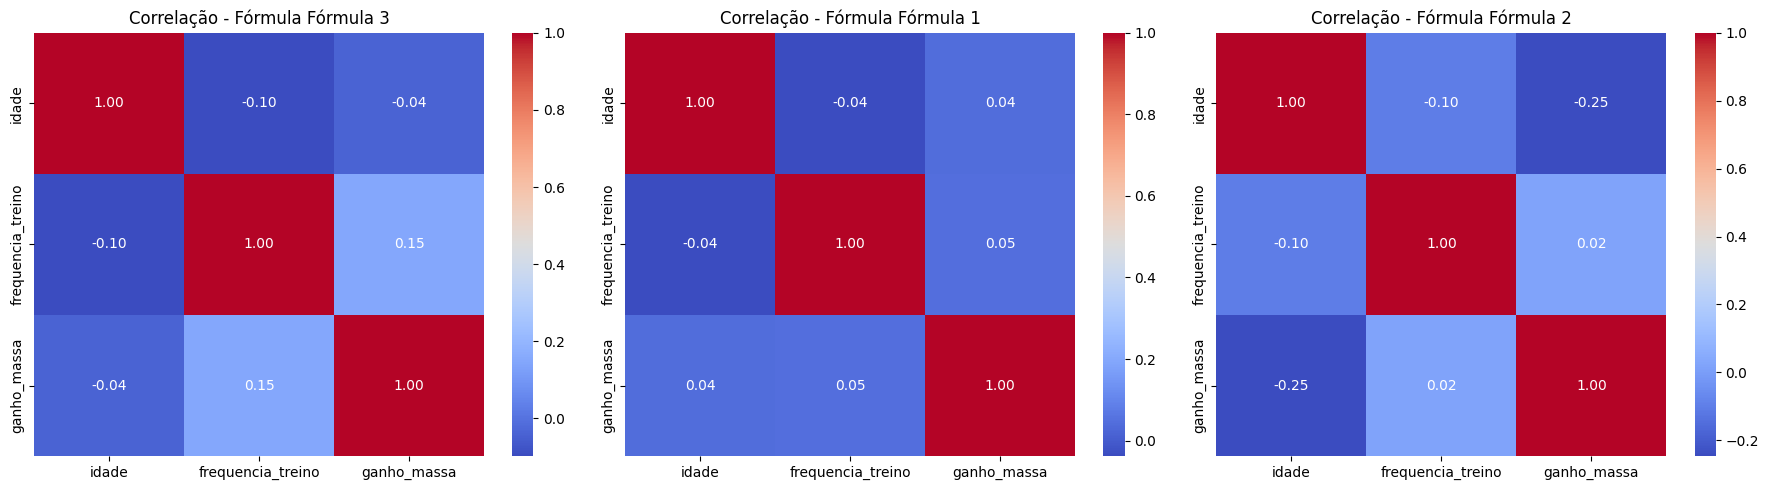

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de produtos (suplementos)
produtos = df['id_produto'].unique()

# Criar subplots em linha
fig, axes = plt.subplots(nrows=1, ncols=len(produtos), figsize=(6 * len(produtos), 5))

# Caso só haja um suplemento
if len(produtos) == 1:
    axes = [axes]

# Gerar um heatmap para cada suplemento
for i, produto in enumerate(produtos):
    df_produto = df[df['id_produto'] == produto]

    # Seleciona colunas para correlação
    corr_matrix = df_produto[['idade', 'frequencia_treino', 'ganho_massa']].corr(method='pearson')

    # Cria o heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[i])
    axes[i].set_title(f'Correlação - Fórmula {produto}')

plt.tight_layout()
plt.show()


* Analisando os heatmaps geral, e por formula, os resultados indicam que não há uma relação linear clara entre frequencia de treinamento, idade e o ganho de massa.

⏩ **Qual fórmula você recomendaria para atletas que treinam mais de 5 vezes por semana? Justifi que sua escolha.**